In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**IMPORTING REQUIRED LIBRARIES**

In [1]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

**DATASET PATHS**

In [3]:
train_df = "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train" 
val_df = "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val" 
test_df = "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test" 

In [6]:
print(os.listdir(train_df))
print(os.listdir(val_df))
print(os.listdir(test_df))

['2', '0', '3', '1', '4']
['2', '0', '3', '1', '4']
['2', '0', '3', '1', '4']


**DATA PREPROCESSING AND AUGMENTATION (NORMALIZATION, RESIZING, FLIPPING, ROTATION)**

In [7]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    dtype=None,
    zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    dtype=None,
    zoom_range = 0.1
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    dtype=None,
    zoom_range = 0.1
)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_df,
    target_size = (224, 224),
    batch_size = 10,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_df,
    target_size = (224, 224),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 34792 images belonging to 5 classes.
Found 9940 images belonging to 5 classes.


In [9]:
train_generator.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

**Load Pretrained ResNet152V2**

In [10]:
base_model = tf.keras.applications.ResNet152V2(input_shape=(224,224,3),include_top=False,weights="imagenet")

234545216/234545216 [==============================] - 8s 0us/step


 **Freezing Initial Layers in ResNet152V2**
 
To **prevent overfitting** and **speed up training**, we **freeze most of the layers** in the **pretrained ResNet152V2 model**, except for the last 10 layers. This allows the model to retain learned features while fine-tuning higher-level features.


In [12]:
for layer in base_model.layers[:-10]:
    layer.trainable=False

**Deep Learning Model: ResNet152V2-based Sequential Model**

This model is built using **Transfer Learning** with **ResNet152V2** as the base feature extractor. Additional dense layers are added to enhance classification performance.

**Model Architecture**
- **Base Model:** `ResNet152V2` (pretrained on ImageNet, frozen except last 10 layers)
- **Dropout Layers:** Prevents overfitting (`rate=0.5`)
- **Batch Normalization:** Normalizes activations to stabilize training
- **Dense Layers:** Fully connected layers with `he_uniform` initialization
- **Activation Function:** ReLU for hidden layers, Softmax for final classification

In [13]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5,activation='softmax'))

**MODEL SUMMARY**

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

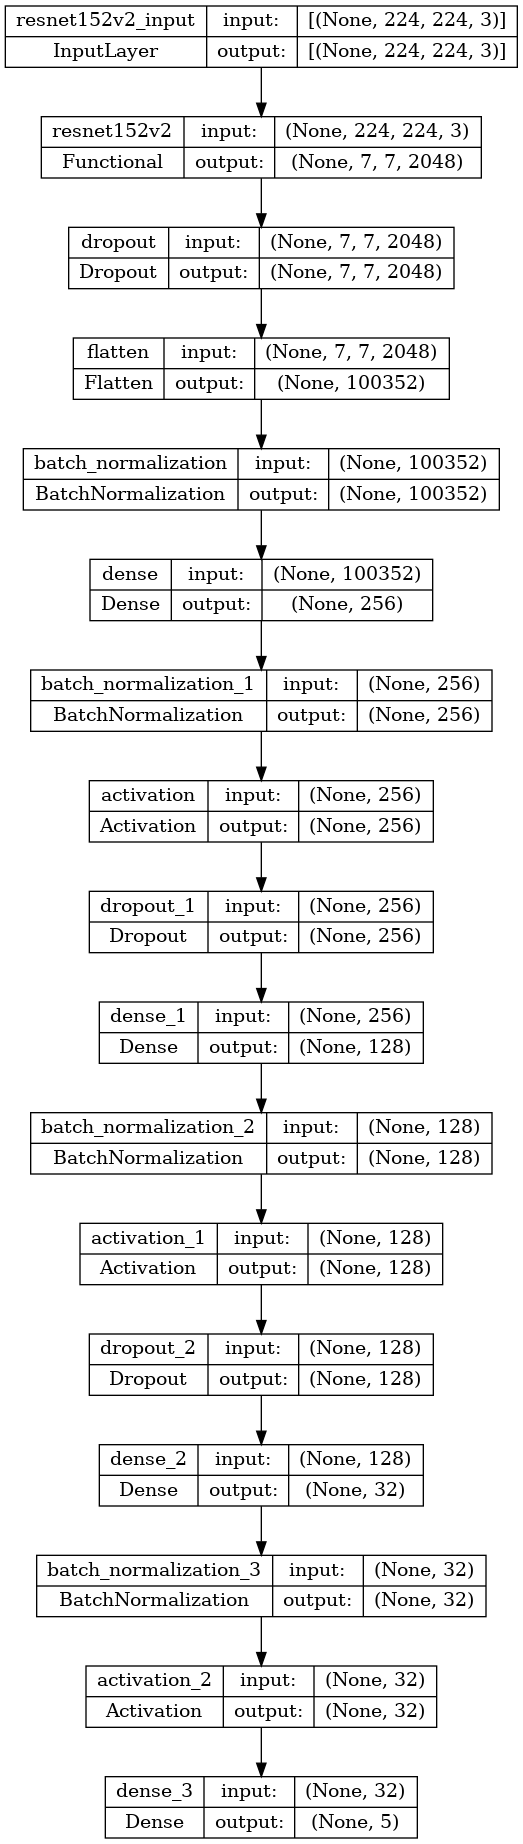

In [15]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

**Compiling the Model**
Before training, we need to **compile** the model by specifying:  
✔ **Optimizer** → Controls how the model updates weights.  
✔ **Loss Function** → Measures how well the model is performing.  
✔ **Metrics** → Defines additional evaluation metrics.

In [17]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc')
]


In [18]:
model.compile(
    optimizer='Adam', 
    loss="categorical_crossentropy",
     metrics=METRICS
)


In [19]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

In [20]:
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

3479
994


**Training the Model**

Once the model is compiled, we train it using the **fit()** function.  
This function updates model weights based on the training data.

In [21]:
history=model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=100,
    validation_data=val_generator,
    validation_steps=1,
    verbose=1,
)

Epoch 1/100
25/25 [==============================] - 86s 3s/step - loss: 1.8072 - accuracy: 0.7808 - auc: 0.5164 - val_loss: 31.7691 - val_accuracy: 0.7200 - val_auc: 0.5575
Epoch 2/100
25/25 [==============================] - 70s 3s/step - loss: 1.7174 - accuracy: 0.7880 - auc: 0.5543 - val_loss: 13.8105 - val_accuracy: 0.6800 - val_auc: 0.5337
Epoch 3/100
25/25 [==============================] - 69s 3s/step - loss: 1.5491 - accuracy: 0.8016 - auc: 0.6412 - val_loss: 5.1188 - val_accuracy: 0.6800 - val_auc: 0.5863
Epoch 4/100
25/25 [==============================] - 69s 3s/step - loss: 1.6450 - accuracy: 0.7936 - auc: 0.5893 - val_loss: 6.7178 - val_accuracy: 0.7000 - val_auc: 0.4738
Epoch 5/100
25/25 [==============================] - 69s 3s/step - loss: 1.6275 - accuracy: 0.7896 - auc: 0.6005 - val_loss: 5.3522 - val_accuracy: 0.6400 - val_auc: 0.4750
Epoch 6/100
25/25 [==============================] - 69s 3s/step - loss: 1.6543 - accuracy: 0.7864 - auc: 0.5814 - val_loss: 2.1330 -

**Saving the Model**

In [47]:
model.save('/kaggle/working/diabetic_retinopathy_model.h5')


**Visualizing Training and Validation Performance**

After training the model, it's important to analyze its performance over epochs.  
We can do this by plotting **training accuracy, validation accuracy, training loss, and validation loss**.

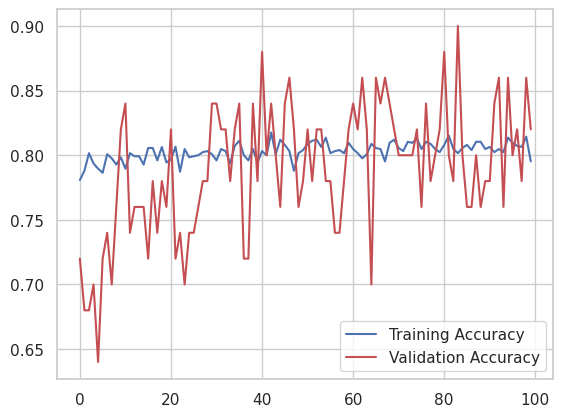

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

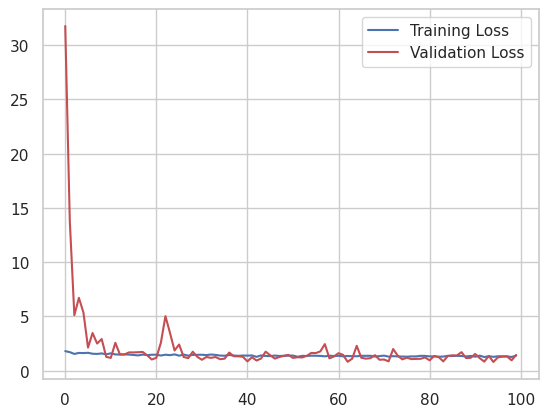

In [23]:
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.legend(loc = 'best')
plt.show()

**DATA AUGMENTATION ON TEST DATA FOR CONSISTENCY**

In [24]:
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    dtype=None,
    zoom_range = 0.1
)

test_generator = test_datagen.flow_from_directory(
    test_df,
    target_size = (224, 224),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 4971 images belonging to 5 classes.


**Saving the Model**

In [44]:
model_save = ModelCheckpoint('/kaggle/working/diabetic_retinopathy_model.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

**MAKING PREDICTIONS ON TEST DATA**

In [28]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

predict_x = model.predict(test_generator)

498/498 [==============================] - 1103s 2s/step


In [31]:
from sklearn.metrics import classification_report,confusion_matrix

 **Evaluating the Model on Train, Validation, and Test Sets**
 
Once the model is trained, we evaluate its performance on different datasets to check for overfitting and generalization.

#### **Model Evaluation**

In [33]:
train_score = model.evaluate(train_generator, verbose= 1)
valid_score = model.evaluate(val_generator, verbose= 1)
test_score = model.evaluate(test_generator, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

498/498 [==============================] - 1074s 2s/step - loss: 1.2855 - accuracy: 0.8061 - auc: 0.7843
Train Loss:  1.288796067237854
Train Accuracy:  0.8066279888153076
Validation Loss:  1.2766993045806885
Validation Accuracy:  0.8075653910636902
Test Loss:  1.2854673862457275
Test Accuracy:  0.806115448474884


**SAVING THE MODEL**

In [70]:
import os

model_path = "./diabetic_retinopathy_model.h5"  
absolute_path = os.path.abspath(model_path)
print("Model is saved at:", absolute_path)


Model is saved at: /kaggle/working/diabetic_retinopathy_model.h5


In [71]:
import os

save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)

model.save(os.path.join(save_dir, "diabetic_retinopathy_model.h5"))
print("Model saved successfully at:", save_dir)


Model saved successfully at: ./saved_models


**SAVING MODEL TRAINING**

In [79]:
import pickle

with open('/kaggle/working/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


**LOADING MODEL FOR PREDICTIONS ON TEST DATA**

In [74]:
from tensorflow.keras.models import load_model

model_path = "/kaggle/working/diabetic_retinopathy_model.h5"  
model = load_model(model_path)


**DEFINING CLASS LABELS**

In [75]:
class_labels = {0: 'No_Dr', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferative DR'}


**Selecting Random Test Images for Model Evaluation**

To test the model's prediction accuracy, we select one random image from each class in the **Diabetic Retinopathy Balanced Dataset**.

In [110]:
import os
#random images
test_images1 = {0: '/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/0/41072_left.jpeg', 
                1:'/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/1/10221_right._aug_15.jpeg',
                2:'/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/2/10156_right.jpeg',
                3:'/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/3/1002_left._aug_27._aug_1.jpeg',
                4:'/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/4/10785_left.jpeg'}

print("Selected Test Images1:", test_images1)


Selected Test Images1: {0: '/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/0/41072_left.jpeg', 1: '/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/1/10221_right._aug_15.jpeg', 2: '/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/2/10156_right.jpeg', 3: '/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/3/1002_left._aug_27._aug_1.jpeg', 4: '/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/4/10785_left.jpeg'}


**Preprocessing Images for Model Prediction**

To ensure our test images match the input format required by the trained model, we define a preprocessing function.

In [77]:
import cv2
import numpy as np

def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)  # Load image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, target_size)  # Resize to match model input
    img = img / 255.0  # Normalize pixel values
    return np.expand_dims(img, axis=0)  # Add batch dimension


**Testing the Model on Sample Images**

Now, we test the trained model using a set of pre-selected images, one from each class, and evaluate its predictions.

**Code for Making Predictions**

In [109]:
for class_id, img_path in test_images1.items():
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Get class with highest probability
    
    print(f"Actual Class: {class_labels[class_id]}")
    print(f"Predicted Class: {class_labels[predicted_class]}")
    print("-" * 50)


1/1 [==============================] - 0s 300ms/step
Actual Class: No_Dr
Predicted Class: No_Dr
--------------------------------------------------
1/1 [==============================] - 0s 303ms/step
Actual Class: Mild
Predicted Class: Mild
--------------------------------------------------
1/1 [==============================] - 0s 298ms/step
Actual Class: Moderate
Predicted Class: Moderate
--------------------------------------------------
1/1 [==============================] - 0s 299ms/step
Actual Class: Severe
Predicted Class: Severe
--------------------------------------------------
1/1 [==============================] - 0s 300ms/step
Actual Class: Proliferative DR
Predicted Class: Proliferative DR
--------------------------------------------------


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels from the test generator
true_labels = test_generator.classes  

# Get predicted probabilities
#pred_probs = model.predict(test_generator)

# Convert probabilities to class labels
pred_labels = np.argmax(predict_x, axis=1)

# Print classification report (includes Precision, Recall, and F1-score)
print(classification_report(true_labels, pred_labels, target_names=test_generator.class_indices.keys()))
